# **Traffic Sign Recognition with Gluon**

## **About DataSet**

### **Belgium Traffic Sign Dataset**
---
Dataset can be obtained from [HERE](http://btsd.ethz.ch/shareddata/).


There are huge datasets, but all we need are only two of those.
- BelgiumTSG_Training(171.3MBytes)
- BelgiumTSC_Testing(76.5Mbytes)



This tutorial uses these two paths:

    /traffic/datasets/BelgiumTS/Training/
    /traffic/datasets/BelgiumTS/Testing/

Each of the two directories contain 62 subdirectories, named sequentially from **00000** to **00061**. The directory names represent the labels, and the images inside each directory are samples of each label.

### **Exploring the Dataset**


In [27]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Allow image embeding in notebook
%matplotlib inline

In [30]:
train_data_dir = '/Users/junui/traffic/datasets/BelgiumTS/Training/'
test_data_dir = '/Users/junui/traffic/datasets/BelgiumTS/Testing/'

#### **Load Images**

In [29]:
def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

images, labels = load_data(train_data_dir)

In [31]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 62
Total Images: 4575


#### **Display Images**

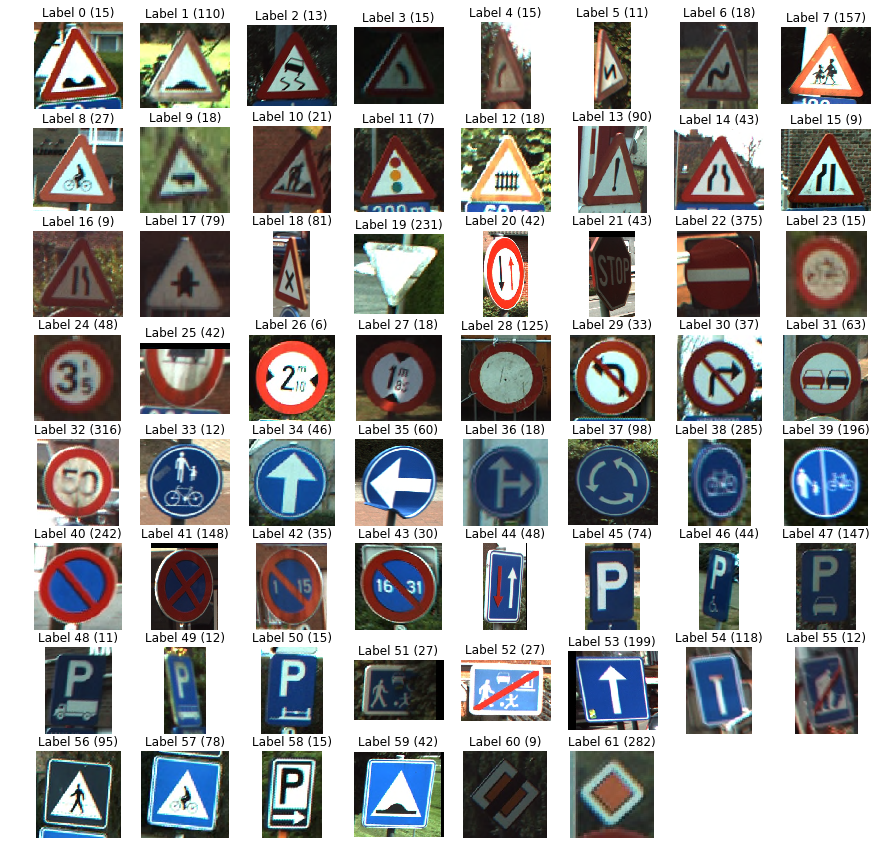

In [32]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

#### **Display Images with Label**

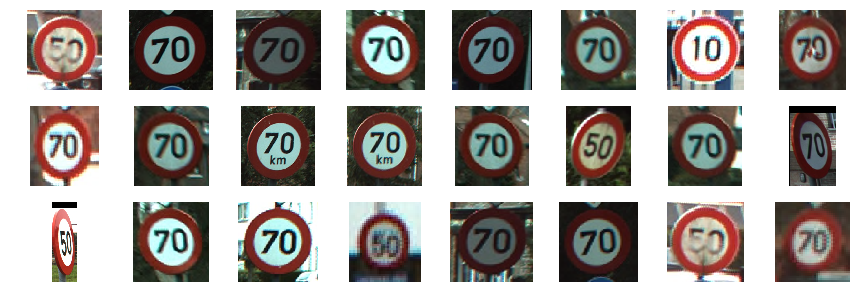

In [33]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 32)

#### **Handling Image's Size**

In [34]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (144, 141, 3), min: 3, max: 255
shape: (183, 187, 3), min: 0, max: 255
shape: (244, 253, 3), min: 0, max: 255
shape: (99, 97, 3), min: 4, max: 247
shape: (145, 146, 3), min: 0, max: 255


/Users/junui/anaconda/envs/tf/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


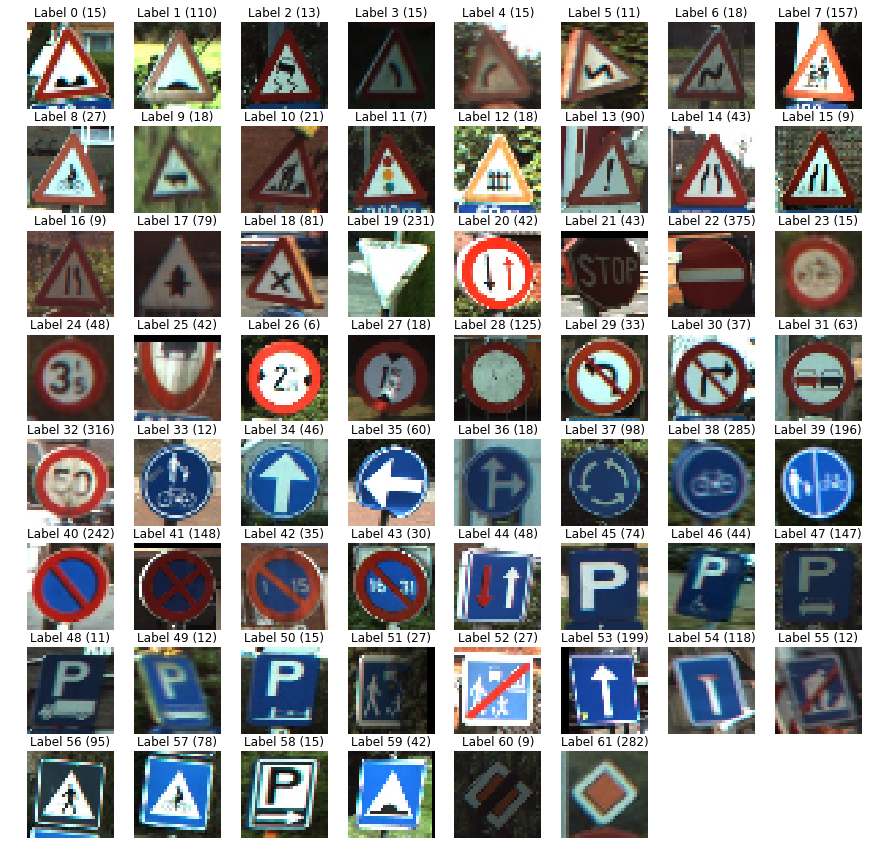

In [35]:
# Resize Images
images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
display_images_and_labels(images32, labels)